* How likely am I to subscribe a term deposit?

* Experimenting of variables selection techniques.

* Explorations of the variables so serves as a good example of Exploratory Data Analysis and how that can guide the model creation and selection process.

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import matplotlib.lines as mlines
import warnings
warnings.filterwarnings('ignore')
from collections import OrderedDict
import theano
import theano.tensor as tt
import itertools
from IPython.core.pylabtools import figsize
pd.set_option('display.max_columns', 30)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [23]:
df = pd.read_csv('banking.csv')

In [24]:
df.head()
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334;1;999;0,nonexistent,-1.1;94.767;-50.8;1.028;4963.6,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383;1;999;0,nonexistent,-1.1;94.767;-50.8;1.028;4963.6,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189;2;999;0,nonexistent,-1.1;94.767;-50.8;1.028;4963.6,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442;1;999;0,nonexistent,-1.1;94.767;-50.8;1.028;4963.6,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN


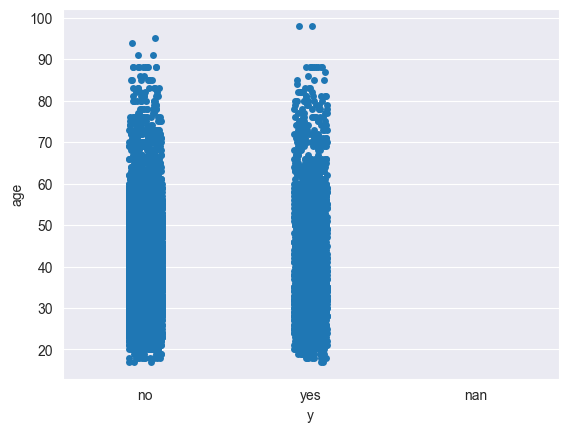

In [25]:
sns.stripplot(x="y", y="age", data=df, jitter=True)
plt.show();

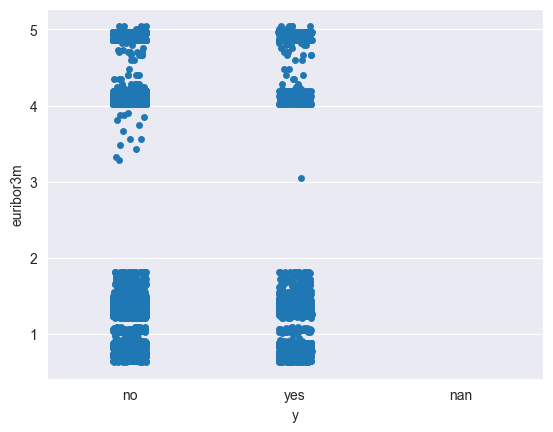

In [26]:
sns.stripplot(x="y", y="euribor3m", data=df, jitter=True)
plt.show();

In [27]:
df['education'].value_counts()

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64

In [28]:
df['job'].value_counts()

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

In [29]:
df.poutcome.unique()

array(['nonexistent', 'failure', 'success', nan], dtype=object)

In [30]:
def replace_education(education):
    """
    This function codes the highest education attained.
    """
    if education == 'university.degree':
        return 8
    elif education == 'professional.course':
        return 7
    elif education == 'high.school':
        return 6
    elif education == 'basic.9y':
        return 5
    elif education == 'basic.6y':
        return 4
    elif education =='basic.4y':
        return 3
    elif education == 'unknown':
        return 2
    elif education == 'illiterate':
        return 1
    
def replace_job(job):
    """
    This function codes the highest job earned.
    """
    if job == 'management':
        return 12
    elif job == 'admin.':
        return 11
    elif job == 'entrepreneur':
        return 10
    elif job == 'technician':
        return 9
    elif job == 'services':
        return 8
    elif job == 'self-employed':
        return 7
    elif job == 'blue-collar':
        return 6
    elif job == 'retired':
        return 5
    elif job == 'housemaid':
        return 4
    elif job == 'unemployed':
        return 3
    elif job == 'unknown':
        return 2
    elif job == 'student':
        return 1
    
def replace_marital(marital):
    if marital == 'married':
        return 4
    elif marital == 'single':
        return 3
    elif marital == 'divorced':
        return 2
    elif marital == 'unknown':
        return 1
    
def replace_default(default):
    if default == 'no':
        return 0
    elif default == 'yes':
        return 1
    elif default == 'unknown':
        return 2
    
def replace_housing(housing):
    if housing == 'no':
        return 0
    elif housing == 'yes':
        return 1
    elif housing == 'unknown':
        return 2

def replace_loan(loan):
    if loan == 'no':
        return 0
    elif loan == 'yes':
        return 1
    elif loan == 'unknown':
        return 2
    
def replace_contact(contact):
    if contact == 'cellular':
        return 1
    elif contact == 'telephone':
        return 2
    
def replace_poutcome(poutcome):
    if poutcome == 'failure':
        return 0
    elif poutcome == 'success':
        return 1
    elif poutcome == 'nonexistent':
        return 2

df['education'] = df['education'].apply(lambda x: replace_education(x))
df['job'] = df['job'].apply(lambda x: replace_job(x))
df['marital'] = df['marital'].apply(lambda x: replace_marital(x))
df['default'] = df['default'].apply(lambda x: replace_default(x))
df['housing'] = df['housing'].apply(lambda x: replace_housing(x))
df['loan'] = df['loan'].apply(lambda x: replace_loan(x))
df['contact'] = df['contact'].apply(lambda x: replace_contact(x))
df['poutcome'] = df['poutcome'].apply(lambda x: replace_poutcome(x))

In [31]:
look_up = {'aug': 8, 'nov': 11, 'jun': 6, 'apr': 4, 'jul': 7,
            'may': 5, 'oct': 10, 'mar': 3, 'sep': 9, 'dec': 12}

df['month'] = df['month'].apply(lambda x: look_up[x])

In [32]:
look_up = {'thu': 4, 'fri': 5, 'tue': 2, 'mon': 1, 'wed': 3}

df['day_of_week'] = df['day_of_week'].apply(lambda x: look_up[x])

In [33]:
df.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,4,4,3,0,0,0,2,5,1,261,1,999,0,2.0,1.1,93.994,-36.4,4.857,5191.0,no
1,57,8,4,6,2,0,0,2,5,1,149,1,999,0,2.0,1.1,93.994,-36.4,4.857,5191.0,no
2,37,8,4,6,0,1,0,2,5,1,226,1,999,0,2.0,1.1,93.994,-36.4,4.857,5191.0,no


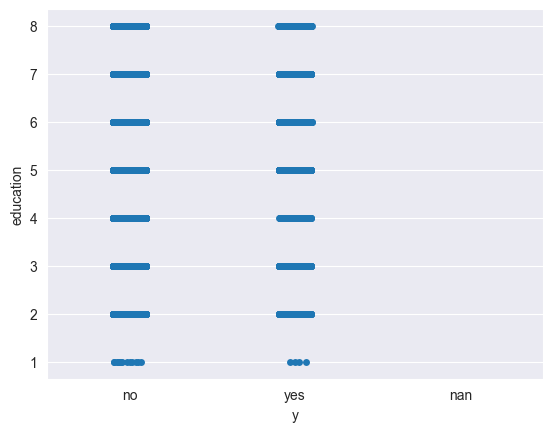

In [34]:
sns.stripplot(x="y", y="education", data=df, jitter=True)
plt.show();

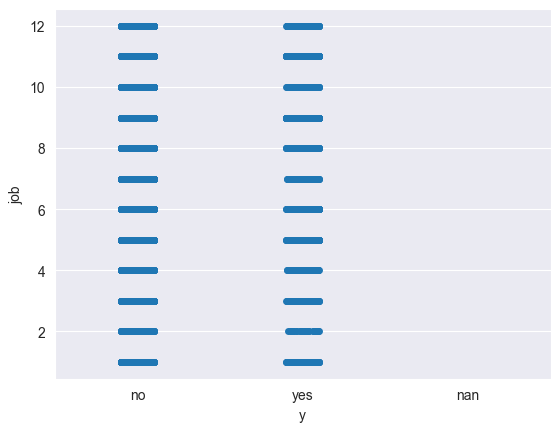

In [35]:
sns.stripplot(x="y", y="job", data=df, jitter=True)
plt.show();

In [36]:
df.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,4,4,3,0,0,0,2,5,1,261,1,999,0,2.0,1.1,93.994,-36.4,4.857,5191.0,no
1,57,8,4,6,2,0,0,2,5,1,149,1,999,0,2.0,1.1,93.994,-36.4,4.857,5191.0,no
2,37,8,4,6,0,1,0,2,5,1,226,1,999,0,2.0,1.1,93.994,-36.4,4.857,5191.0,no


In [37]:
outcome = df['y']
data = df[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'euribor3m']]
data['outcome'] = outcome
df.head(3)
# data.corr()['outcome'].sort_values(ascending=False)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,4,4,3,0,0,0,2,5,1,261,1,999,0,2.0,1.1,93.994,-36.4,4.857,5191.0,no
1,57,8,4,6,2,0,0,2,5,1,149,1,999,0,2.0,1.1,93.994,-36.4,4.857,5191.0,no
2,37,8,4,6,0,1,0,2,5,1,226,1,999,0,2.0,1.1,93.994,-36.4,4.857,5191.0,no


## Logistic Regression with one independent variable

In [38]:
y_simple = data['outcome']
x_n = 'duration' 
x_0 = data[x_n].values
print(x_0)
x_c = x_0 - x_0.mean()

with pm.Model() as model_simple:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)

    μ = α + pm.math.dot(x_c, β)
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -α/β)

    y_1 = pm.Bernoulli('y_1', p=θ, observed=y_simple)

    trace_simple = pm.sample(1000, tune=1000)

[261 149 226 ... '189;2;999;0' '442;1;999;0' '239;3;999;1']


TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [ ]:
theta = trace_simple['θ'].mean(axis=0)
idx = np.argsort(x_c)
plt.plot(x_c[idx], theta[idx], color='C2', lw=3)
plt.vlines(trace_simple['bd'].mean(), 0, 1, color='k')
bd_hpd = az.hpd(trace_simple['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='k', alpha=0.5)

plt.scatter(x_c, np.random.normal(y_simple, 0.02),
            marker='.', color=[f'C{x}' for x in y_simple])
az.plot_hpd(x_c, trace_simple['θ'], color='C2')

plt.xlabel(x_n)
plt.ylabel('θ', rotation=0)
locs, _ = plt.xticks()
plt.xticks(locs, np.round(locs + x_0.mean(), 1));

In [ ]:
az.summary(trace_simple, var_names=['α', 'β'])

In [ ]:
ppc = pm.sample_ppc(trace_simple, model=model_simple, samples=500)
preds = np.rint(ppc['y_1'].mean(axis=0)).astype('int')

In [ ]:
print('Accuracy of the simplest model:', accuracy_score(preds, data['outcome']))
print('f1 score of the simplest model:', f1_score(preds, data['outcome']))

In [ ]:
outcome.value_counts()

In [ ]:
plt.figure(figsize=(15, 15))
corr = data.corr() 
mask = np.tri(*corr.shape).T 
sns.heatmap(corr.abs(), mask=mask, annot=True, cmap='viridis');

In [ ]:
# Scale age by 10, it helps with model convergence.
data['age'] = data['age'] / 10
data['age2'] = np.square(data['age'])

## Define model using PyMC3 GLM method

PyMC3 has a module - glm - for defining models using a patsy-style formula syntax. This seems really useful, especially for defining models in fewer lines of code.

In [ ]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula('outcome ~ age + age2 + job + marital + education + default + housing + loan + contact + month + day_of_week + duration + campaign + pdays + previous + euribor3m', data, family = pm.glm.families.Binomial())
    trace = pm.sample(1000, tune = 1000, init = 'adapt_diag')

In [ ]:
az.plot_trace(trace);

Each curve shows how the probability of subscribing a term deposit changes with age, given this customer is married.

The red curve represents university degree, the green curve represents and basic.9y education, the blue curve represents illiterate. For all three education levels, the probability of subscribing a term deposit decreases with age until approximately age 40, when the probability begins to increase. Notice that every curve is blurry. This is because we are actually plotting 100 different curves for each level of education. Each curve is a draw from our posterior distribution. 

In [ ]:
def lm_full(trace, age, education, marital):
    shape = np.broadcast(age, education, marital).shape
    x_norm = np.asarray([np.broadcast_to(x, shape) for x in [age/10., education, marital]])
    
    return 1 / (1 + np.exp(-(trace['Intercept'] + 
                             trace['age']*x_norm[0] + 
                             trace['age2']*(x_norm[0]**2) +
                             trace['education']*x_norm[1] +
                             trace['marital']*x_norm[2])))

lm = lambda x, samples: lm_full(samples, x, 1., 4.)
lm2 = lambda x, samples: lm_full(samples, x, 5., 4.)
lm3 = lambda x, samples: lm_full(samples, x, 8., 4.)

In [ ]:
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(25,75,1000), lm=lm, samples=100, color='blue', alpha=.8)
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(25,75,1000), lm=lm2, samples=100, color='green', alpha=.8)
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(25,75,1000), lm=lm3, samples=100, color='red', alpha=.8)

blue_line = mlines.Line2D(['lm'], [], color='b', label='illiterate')
green_line = mlines.Line2D(['lm2'], [], color='g', label='basic.9y') 
red_line = mlines.Line2D(['lm3'], [], color='r', label='university.degree')
plt.legend(handles=[blue_line, green_line, red_line], loc='lower right')
plt.ylabel("P(Outcome = Yes)")
plt.xlabel("Age")
plt.show();

## Estimate Odds Ratio

In [ ]:
b = trace['education']
plt.hist(np.exp(b), bins=20, normed=True)
plt.xlabel("Odds Ratio")
plt.show();

In [ ]:
lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)
print("P(%.3f < Odds Ratio < %.3f) = 0.95" % (np.exp(lb), np.exp(ub)))

We can interpret something along those lines: "With probability 0.95 the odds ratio is greater than 1.055 and less than 1.108, so the education effect takes place because a person with a higher education level has at least 1.055  higher probability to subscribe to a term deposit than a person with a lower education level, while holding all the other variables constant."

Compute odds ratio and percentage effect for all the variables.

In [ ]:
stat_df = pm.summary(trace)
stat_df['odds_ratio'] = np.exp(stat_df['mean'])
stat_df['percentage_effect'] = 100 * (stat_df['odds_ratio'] - 1)
stat_df

with a one unit increase in education, the odds of subscribing to a term deposit increases by 8%. Similarly, for a one unit increase in euribor3m, the odds of subscribing to a term deposit decreases by 43%. holding all other independent variables constant.

## Credible Interval

In [ ]:
az.plot_forest(trace);

There's a baseline probability of subscribing a term deposit. Beyond that, age has the biggest effect on subscribing.

In [ ]:
pm.plot_posterior(trace);

## Compare models using Widely-applicable Information Criterion (WAIC)

In [ ]:
def run_models(df, upper_order=5):
    '''
    Convenience function:
    Fit a range of pymc3 models of increasing polynomial complexity.
    Suggest limit to max order 5 since calculation time is exponential.
    '''

    models, traces = OrderedDict(), OrderedDict()

    for k in range(1,upper_order+1):

        nm = 'k{}'.format(k)
        fml = create_poly_modelspec(k)

        with pm.Model() as models[nm]:

            print('\nRunning: {}'.format(nm))
            pm.glm.GLM.from_formula(fml, df,
                                    family=pm.glm.families.Binomial())

            traces[nm] = pm.sample(1000, tune=1000, init='adapt_diag')

    return models, traces

def create_poly_modelspec(k=1):
    '''
    Convenience function:
    Create a polynomial modelspec string for patsy
    '''
    return ('outcome ~ age + job + marital + education + default + housing + loan + contact + month + day_of_week + duration + campaign + pdays + previous + euribor3m ' + ' '.join(['+ np.power(age,{})'.format(j)
                                     for j in range(2,k+1)])).strip()

models_lin, traces_lin = run_models(data, 3)

In [ ]:
model_trace_dict = dict()
for nm in ['k1', 'k2', 'k3']:
    models_lin[nm].name = nm
    model_trace_dict.update({models_lin[nm]: traces_lin[nm]})

dfwaic = pm.compare(model_trace_dict, ic='WAIC')
print(dfwaic)
pm.compareplot(dfwaic);

In [ ]:
dfwaic

## Posterior predictive check

We are going to calculate the metrics using the mean value of the parameters as a "most likely" estimate.

In [ ]:
ppc = pm.sample_ppc(trace, model=logistic_model, samples=500)

In [ ]:
ppc['y'].mean(axis=0)

In [ ]:
preds = np.rint(ppc['y'].mean(axis=0)).astype('int')

In [ ]:
def plot_confusion_matrix(cm, classes = ['Not subscribe', 'Subscribe'],
                          title='Subscription Confusion matrix',
                          cmap=plt.cm.Reds):
    
    # Display the matrix in text form
    print('Confusion matrix')
    print(cm)
    figsize(8, 8)
    
    # Show the matrix using the imshow functionality
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 20)
    
    # Tick marks show classes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 12)
    plt.yticks(tick_marks, classes, rotation = 90, size = 12)

    # Formatting for text labels on plot
    fmt1 = 's'
    fmt2 = 'd'
    thresh = cm.max() / 2.
    
    # Four types of classifications
    types = [['True Negative', 'False Positive'],
             ['False Negative', 'True Positive']]
    
    # Add the actual numbers and the types onto the heatmap plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i - 0.05, format(types[i][j], fmt1),
                 horizontalalignment="center", size = 18,
                 color="white" if cm[i, j] > thresh else "black")
        
        plt.text(j, i + 0.15, format(cm[i, j], fmt2),
                 horizontalalignment="center", size = 24,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size = 16)
    plt.xlabel('Predicted Label', size = 16)

In [ ]:
cm = confusion_matrix(data['outcome'], preds)
plot_confusion_matrix(cm)

In [ ]:
print('Accuracy of the full model: ', accuracy_score(preds, data['outcome']))
print('f1 score of the full model: ', f1_score(preds, data['outcome']))